In [5]:
import pandas as pd
reviews = pd.read_csv('reviews2.csv')

In [6]:
reviews.shape

(1707861, 9)

In [7]:
comment=reviews.drop(columns=['review_id','user_id','business_id','stars','useful','funny','cool','date'],axis=1)

In [8]:
comment2 = comment.head(100)

In [9]:
import re

comment2['text_processed'] = \
comment2['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
comment2['text_processed'] = \
comment2['text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
comment2['text_processed'].head()

/Users/zhudi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/zhudi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    very upscale and romantic place good was excep...
1    the food is always great here the service from...
2    literally the slowest and worst service i have...
3    i have been here twice and have had really goo...
4    went here with an friend visiting from italy: ...
Name: text_processed, dtype: object

In [10]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['use','food','good','place'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = comment2.text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

/Users/zhudi/opt/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/Users/zhudi/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/Users/zhudi/opt/anac

['upscale', 'romantic', 'exceptionally', 'appetizer', 'entree', 'finally', 'mouth', 'watering', 'dessert', 'servers', 'pleasant', 'ambiance', 'warm', 'welcoming']


[nltk_data] Downloading package stopwords to /Users/zhudi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
pip install -U gensim

Requirement already up-to-date: gensim in /Users/zhudi/opt/anaconda3/lib/python3.7/site-packages (4.0.1)
Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
os.chdir('..')

In [12]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]


In [13]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"service" + 0.007*"like" + 0.006*"ordered" + 0.005*"also" + '
  '0.005*"get" + 0.005*"restaurant" + 0.005*"experience" + 0.004*"great" + '
  '0.004*"well" + 0.004*"bar"'),
 (1,
  '0.009*"great" + 0.009*"service" + 0.008*"time" + 0.007*"came" + '
  '0.006*"would" + 0.005*"really" + 0.005*"love" + 0.005*"ordered" + '
  '0.005*"like" + 0.005*"know"'),
 (2,
  '0.010*"like" + 0.009*"get" + 0.008*"one" + 0.008*"great" + 0.007*"service" '
  '+ 0.006*"really" + 0.006*"burger" + 0.006*"first" + 0.005*"menu" + '
  '0.005*"fries"'),
 (3,
  '0.007*"like" + 0.006*"great" + 0.005*"delicious" + 0.005*"back" + '
  '0.005*"restaurant" + 0.004*"fresh" + 0.004*"try" + 0.004*"know" + '
  '0.003*"waitress" + 0.003*"well"'),
 (4,
  '0.011*"great" + 0.009*"like" + 0.005*"service" + 0.005*"back" + '
  '0.005*"best" + 0.005*"area" + 0.005*"know" + 0.005*"burger" + '
  '0.005*"always" + 0.004*"cheese"'),
 (5,
  '0.013*"great" + 0.010*"also" + 0.006*"service" + 0.006*"got" + 0.006*"time" '
  '+ 0.0

In [14]:
topics = [lda_model[corpus[i]] for i in range(len(data))]

In [21]:
topics

[[(3, 0.9399905)],
 [(9, 0.9437391)],
 [(0, 0.9526225)],
 [(1, 0.26529557), (4, 0.26178673), (8, 0.46808502)],
 [(8, 0.95908517)],
 [(0, 0.98988557)],
 [(0, 0.010001531),
  (1, 0.010002081),
  (2, 0.010001458),
  (3, 0.010001816),
  (4, 0.010001915),
  (5, 0.010001944),
  (6, 0.0100010615),
  (7, 0.01000112),
  (8, 0.010001646),
  (9, 0.9099854)],
 [(2, 0.94374204)],
 [(7, 0.9929084)],
 [(0, 0.967851)],
 [(2, 0.96249384)],
 [(0, 0.91816825)],
 [(9, 0.9470471)],
 [(5, 0.98928106)],
 [(1, 0.97631156)],
 [(0, 0.9590824)],
 [(6, 0.9977197)],
 [(5, 0.98675996)],
 [(3, 0.98915166)],
 [(4, 0.99117357)],
 [(4, 0.98901844)],
 [(5, 0.98162794)],
 [(3, 0.98268926)],
 [(9, 0.91817087)],
 [(1, 0.66316175), (6, 0.3278402)],
 [(3, 0.9808442)],
 [(3, 0.93998927)],
 [(1, 0.9876672)],
 [(2, 0.9470476)],
 [(0, 0.9099811),
  (1, 0.010003007),
  (2, 0.01000175),
  (3, 0.010001932),
  (4, 0.01000198),
  (5, 0.010002239),
  (6, 0.010001781),
  (7, 0.010001804),
  (8, 0.0100024175),
  (9, 0.010002048)],
 [(2,

In [23]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

In [24]:
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [25]:
document_topic.head()

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.000000,0.0,0.939991,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.943739
2,0.952622,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,0.000000,0.265296,0.0,0.000000,0.261787,0.0,0.0,0.0,0.468085,0.000000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.959085,0.000000


In [28]:
maxValueIndexObj = document_topic.idxmax(axis=1)
maxValueIndexObj

0     3
1     9
2     0
3     8
4     8
     ..
95    6
96    9
97    5
98    5
99    0
Length: 100, dtype: int64

In [33]:
from wordcloud import WordCloud

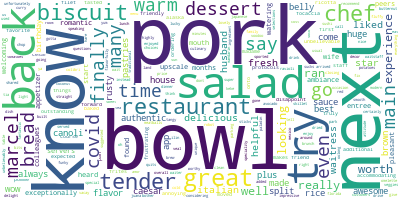

In [73]:
comment_3 = comment2[maxValueIndexObj==3]
data3 = comment_3.text_processed.values.tolist()
data_words3 = list(sent_to_words(data3))
# remove stop words
data_words3 = remove_stopwords(data_words3)
import numpy as np
a = list(np.concatenate(data_words3).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

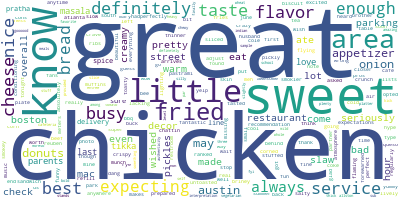

In [74]:
comment_4 = comment2[maxValueIndexObj==4]
data4 = comment_4.text_processed.values.tolist()
data_words4 = list(sent_to_words(data4))
# remove stop words
data_words4 = remove_stopwords(data_words4)
import numpy as np
a = list(np.concatenate(data_words4).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

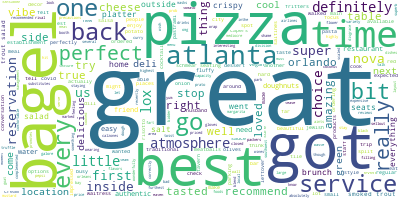

In [75]:
comment_5 = comment2[maxValueIndexObj==5]
data5 = comment_5.text_processed.values.tolist()
data_words5 = list(sent_to_words(data5))
# remove stop words
data_words5 = remove_stopwords(data_words5)
import numpy as np
a = list(np.concatenate(data_words5).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

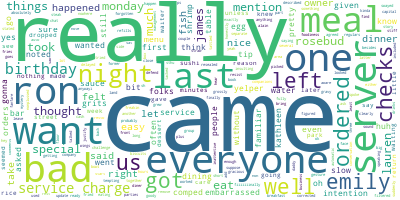

In [76]:
comment_6 = comment2[maxValueIndexObj==6]
data6 = comment_6.text_processed.values.tolist()
data_words6 = list(sent_to_words(data6))
# remove stop words
data_words6 = remove_stopwords(data_words6)
import numpy as np
a = list(np.concatenate(data_words6).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

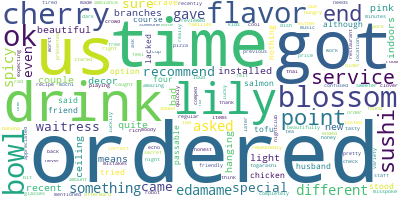

In [78]:
comment_7 = comment2[maxValueIndexObj==7]
data7 = comment_7.text_processed.values.tolist()
data_words7 = list(sent_to_words(data7))
# remove stop words
data_words7 = remove_stopwords(data_words7)
import numpy as np
a = list(np.concatenate(data_words7).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

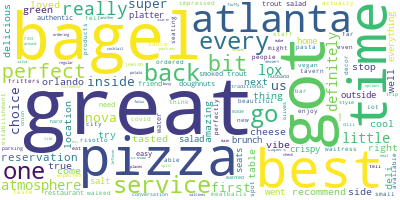

In [79]:
comment_8 = comment2[maxValueIndexObj==8]
data8 = comment_8.text_processed.values.tolist()
data_words8 = list(sent_to_words(data8))
# remove stop words
data_words8 = remove_stopwords(data_words8)
import numpy as np
a = list(np.concatenate(data_words5).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

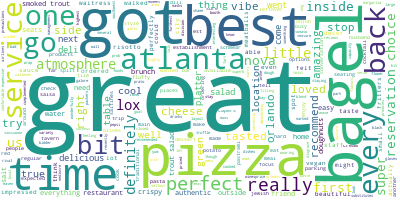

In [80]:
comment_9 = comment2[maxValueIndexObj==9]
data9 = comment_9.text_processed.values.tolist()
data_words9 = list(sent_to_words(data9))
# remove stop words
data_words9 = remove_stopwords(data_words9)
import numpy as np
a = list(np.concatenate(data_words5).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()